$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\var}{var}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \DeclareMathOperator{\GP}{\mathcal{GP}}
    \DeclareMathOperator{\l}{\mathscr{l}}
    \newcommand{\Tn}{\mathrm{T}_{n}}
    \newcommand{\Tx}{\mathrm{T}_{x}}
$$

Build the pipeline to get the data into STAN.

In [1]:
# executing this cell will install all required julia packages
import Pkg
Pkg.activate(".")
Pkg.instantiate()

 Activating environment at `~/Documents/Harvard/Natesh/TemperatureImputations/notebooks/Project.toml`


In [2]:
using StanSample, MCMCChains

using TimeSeries
using DataFrames
using GaussianProcesses
# using GaussianProcesses: Mean, Kernel, evaluate, metric, IsotropicData, VecF64
# using GaussianProcesses: Stationary, KernelData, MatF64, predict
# import GaussianProcesses: optimize!, get_optim_target, cov, grad_slice!
# import GaussianProcesses: num_params, set_params!, get_params, update_mll!, update_mll_and_dmll!
# import GaussianProcesses: get_param_names, cov!, addcov!, multcov!
import Proj4
using Optim
using Distances
# using DataFrames: by, head
using Dates: tonext, Hour, Day
using Distributions
import LinearAlgebra
import PDMats
using Printf
;

In [3]:
using Revise
import TemperatureImputations

┌ Info: Precompiling TemperatureImputations [3ecd16f4-a557-4f5c-bed7-042ea12fe1be]
└ @ Base loading.jl:1278


In [4]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(12,8))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Data import and preprocessing

In [5]:
include("iowa.jl")
data_dir = "../data"
iowa = prepare_iowa_data(data_dir);

# Visualizing Test Data: Tn and Tx

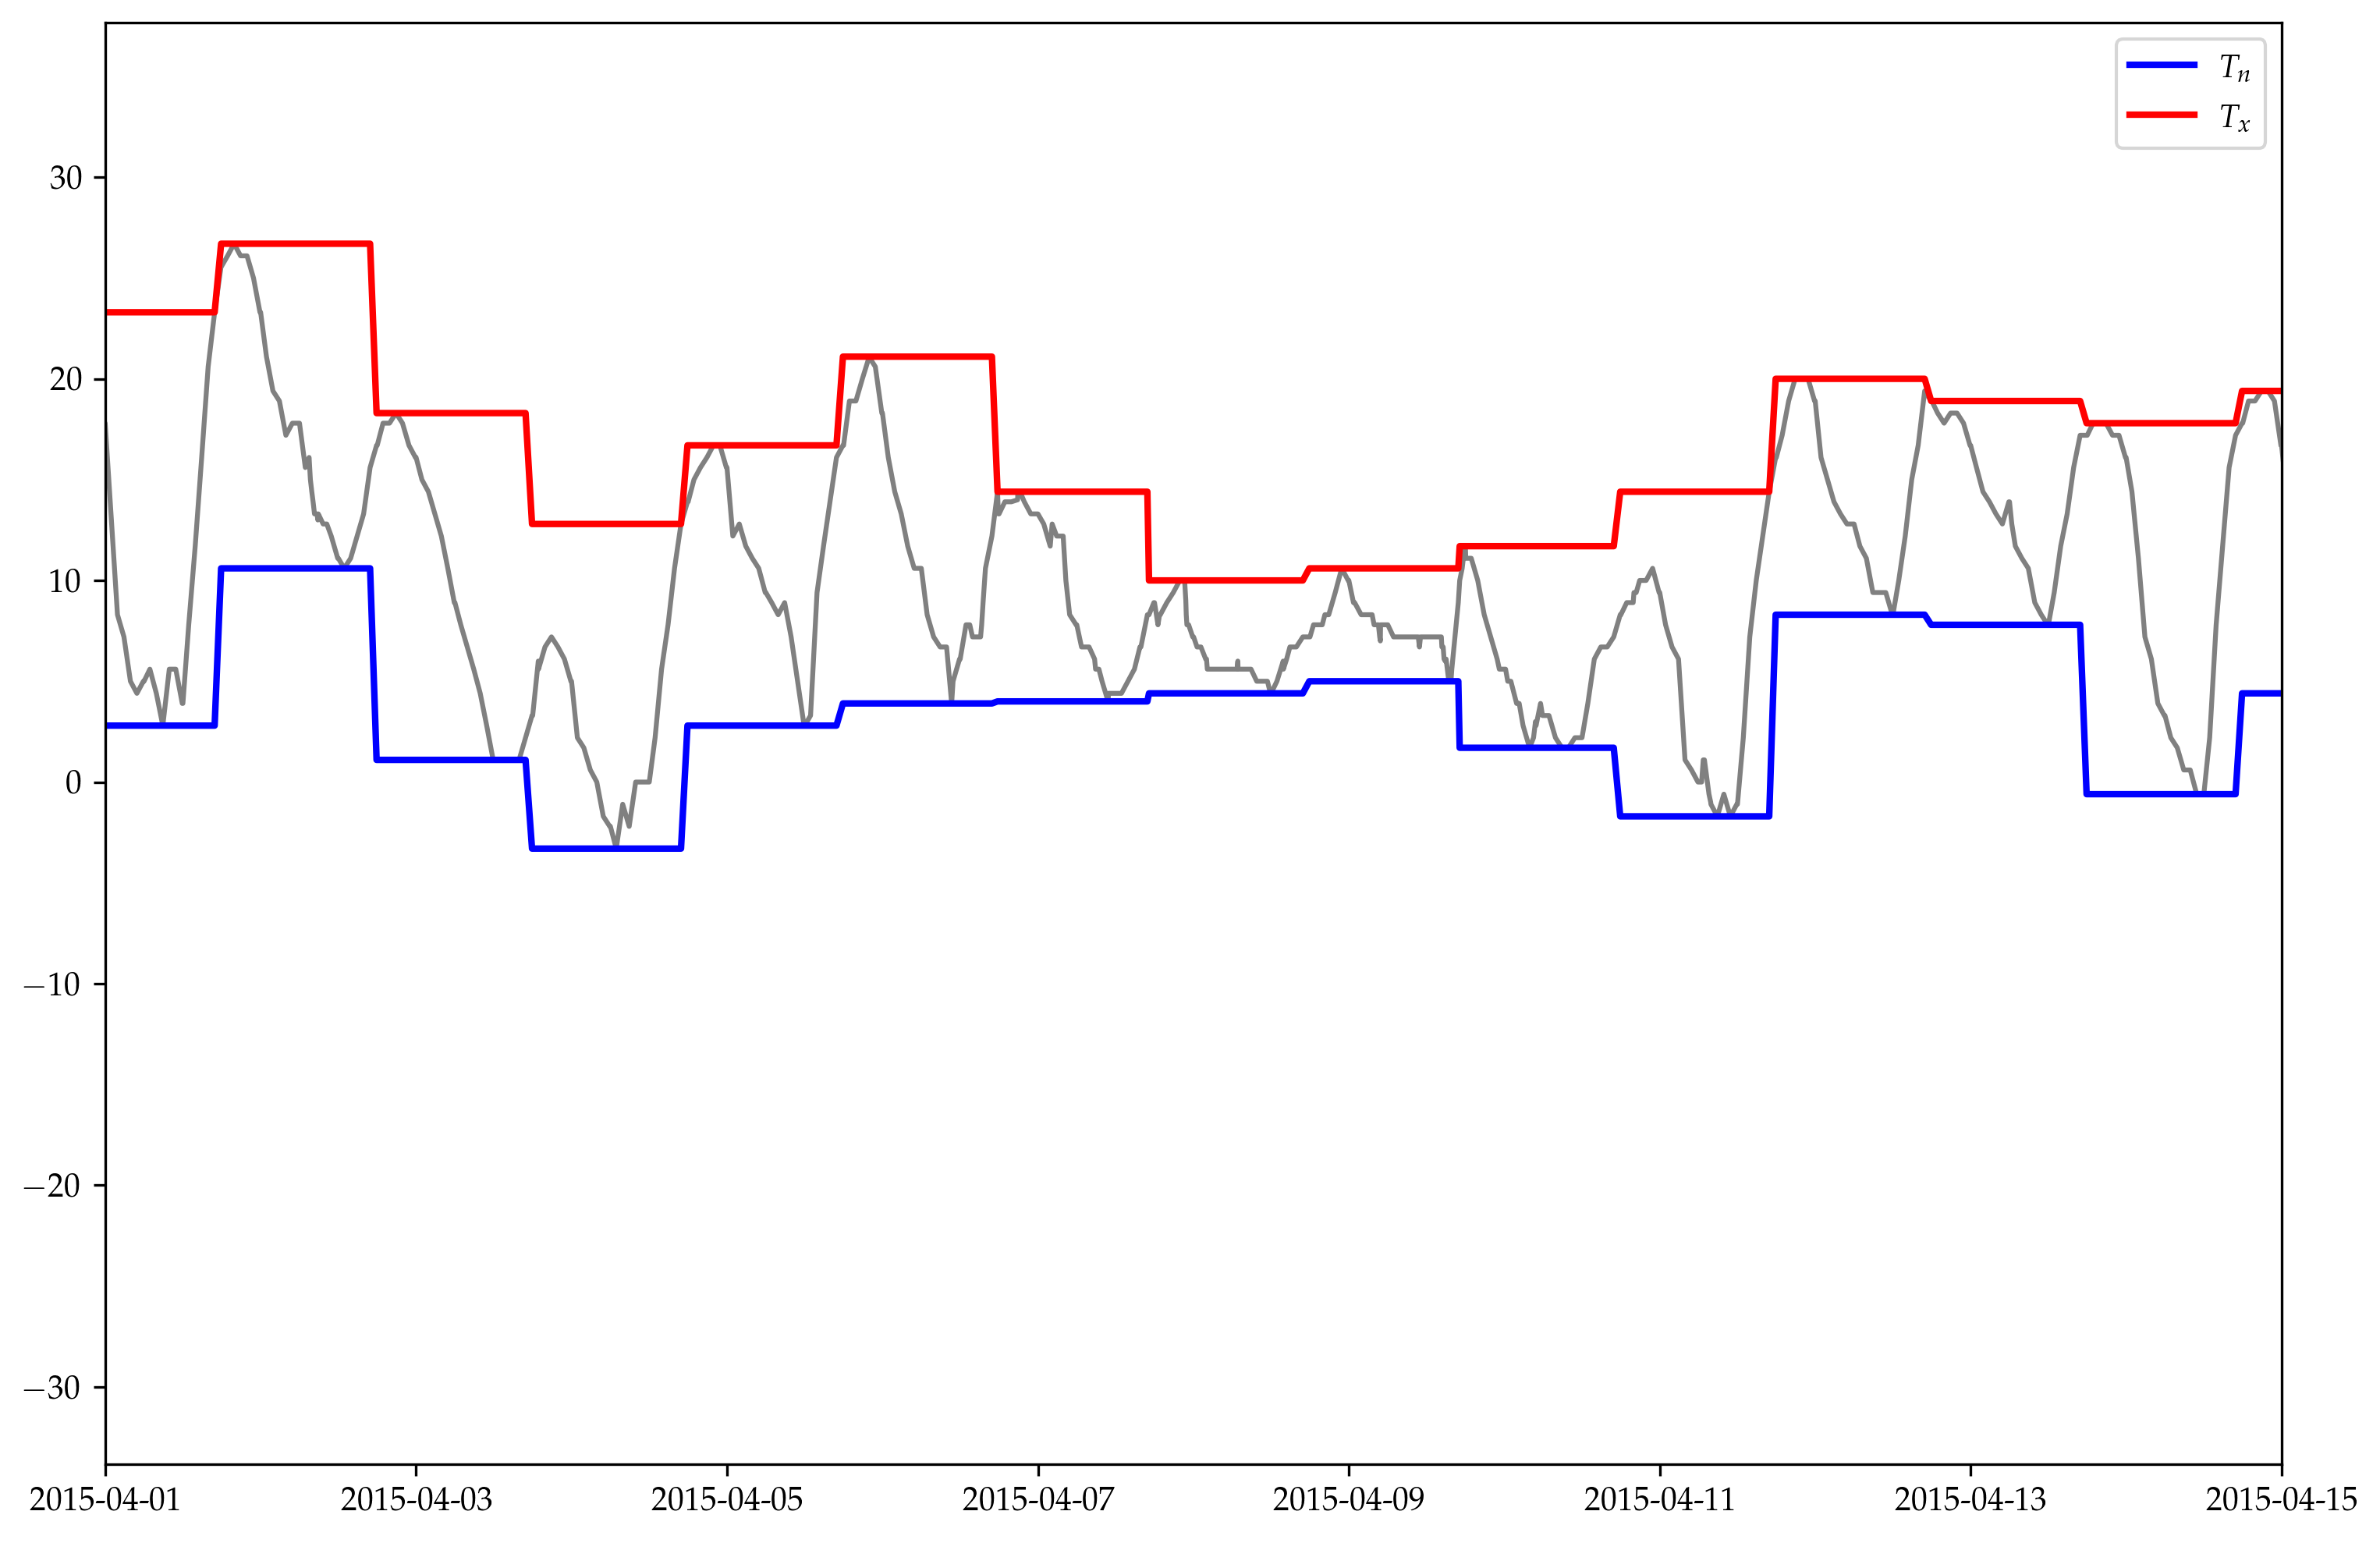

In [6]:
let
    test = iowa[:hourly_test]
    plt.plot(test.ts, test.temp, color="grey")
    plt.plot(test.ts, test.Tn, color="blue", linewidth=2, label=L"$T_n$")
    plt.plot(test.ts, test.Tx, color="red", linewidth=2, label=L"$T_x$")
    plt.xlim(DateTime(2015,4,1),DateTime(2015,4,15)) # random interval
    plt.legend()
end
;

# Kernel Specification

In [7]:
k_spatiotemporal, logNoise = TemperatureImputations.fitted_sptemp_SExSE(;kmean=true)

(Type: SumKernel{ProdKernel{Masked{SEIso{Float64},1},Masked{FixedKernel{SEIso{Float64},1},2}},FixedKernel{Masked{Noise{Float64},2},0}}
  Type: ProdKernel{Masked{SEIso{Float64},1},Masked{FixedKernel{SEIso{Float64},1},2}}
    Type: Masked{SEIso{Float64},1}, Params: [0.996834, 1.3172]    Type: Masked{FixedKernel{SEIso{Float64},1},2}, Params: [12.0805]  Type: FixedKernel{Masked{Noise{Float64},2},0}, Params: Float64[], -0.822261)

# Fitting GP on training data

In [8]:
dt_start, dt_end = DateTime(2015,5,25,18,0,0), DateTime(2015,6,3,16,0,0)
train_subset = TemperatureImputations.subset(iowa[:hourly_train], dt_start, dt_end)
test_subset  = TemperatureImputations.subset(iowa[:hourly_test],  dt_start, dt_end)

avgtemp=combine(groupby(train_subset, :station), df->DataFrame(avgtemp=mean(df.temp)))
train_subset = leftjoin(train_subset, avgtemp, on=:station)

train_X_PRJ = iowa[:isdSubset].X_PRJ[train_subset.station]
train_Y_PRJ = iowa[:isdSubset].Y_PRJ[train_subset.station]
train_X = [train_subset.ts_hours train_X_PRJ train_Y_PRJ]
train_Y = train_subset.temp .- train_subset.avgtemp

test_X_PRJ = iowa[:isdSubset].X_PRJ[test_subset.station]
test_Y_PRJ = iowa[:isdSubset].Y_PRJ[test_subset.station]
test_X = [test_subset.ts_hours test_X_PRJ test_Y_PRJ]
;

In [9]:
train_GP = GP(train_X', train_Y, MeanZero(), k_spatiotemporal, logNoise);

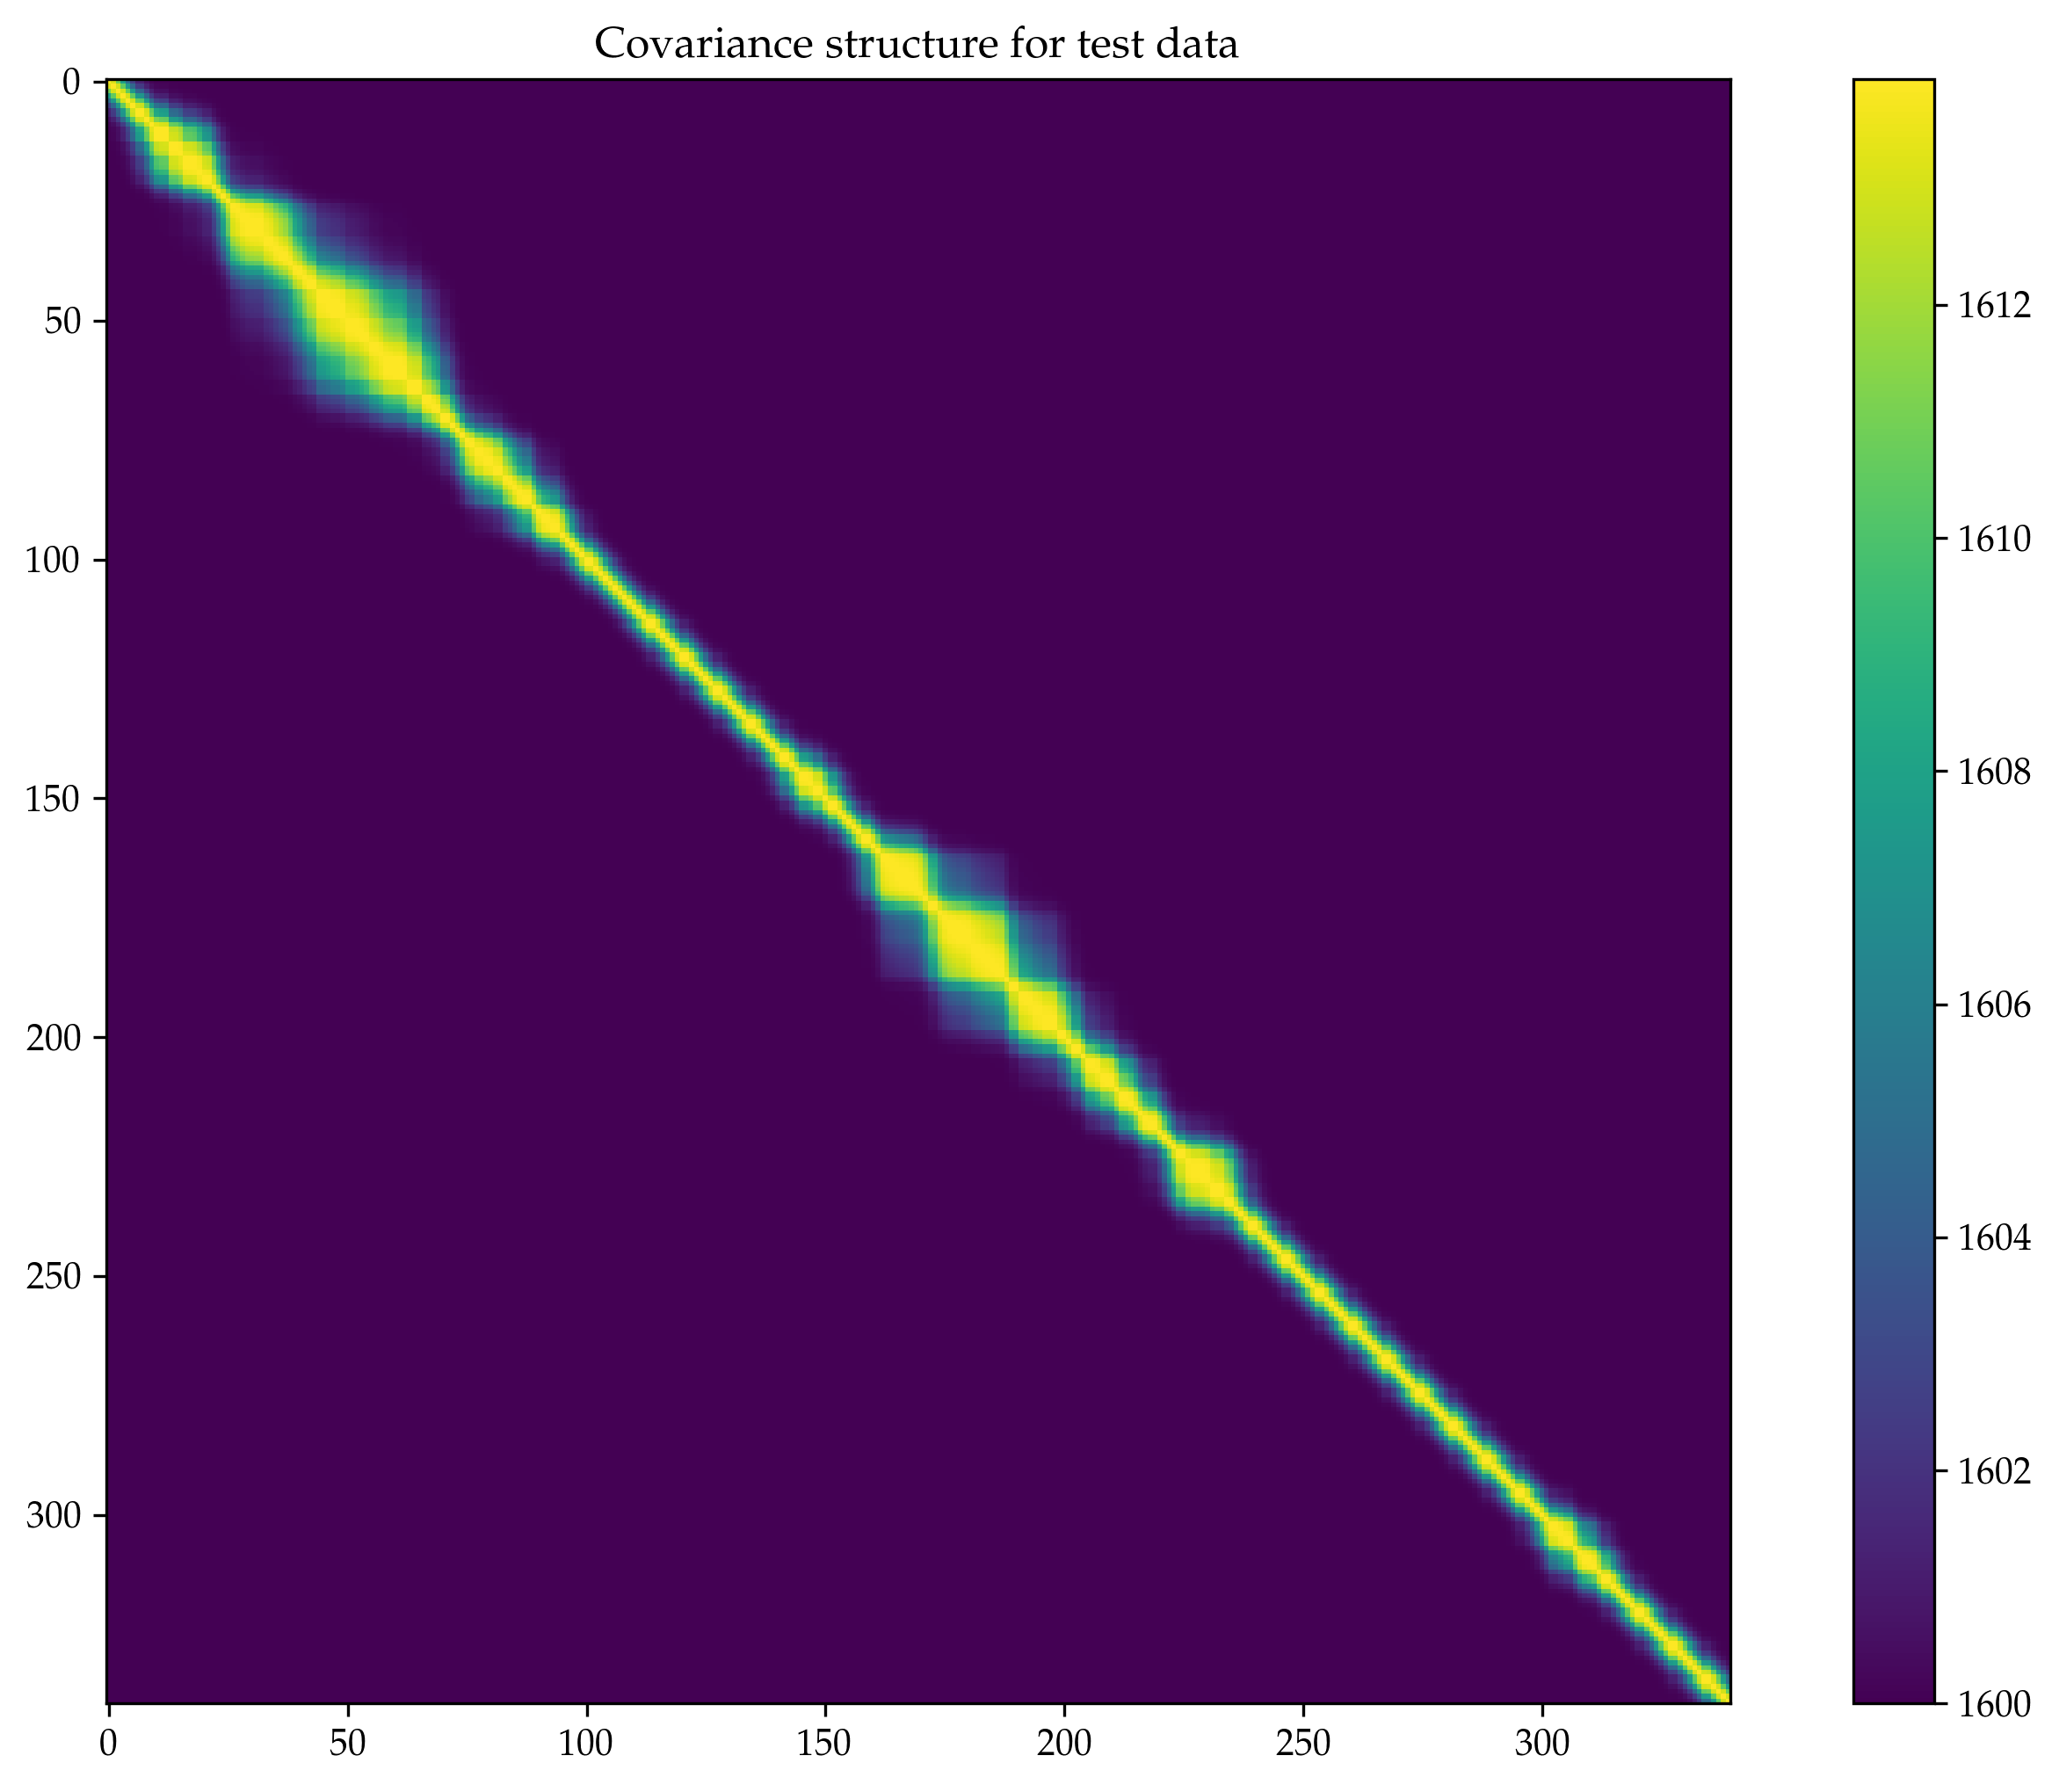

PyObject <matplotlib.colorbar.Colorbar object at 0x168c6bc70>

In [10]:
plt.imshow(cov(k_spatiotemporal, test_X'))
plt.title("Covariance structure for test data")
plt.colorbar()

## Predicting at the test location

In [11]:
test_prediction=predict_f(train_GP, test_X'; full_cov=true)
TemperatureImputations.add_diag!(test_prediction[2], exp(2*logNoise))
;

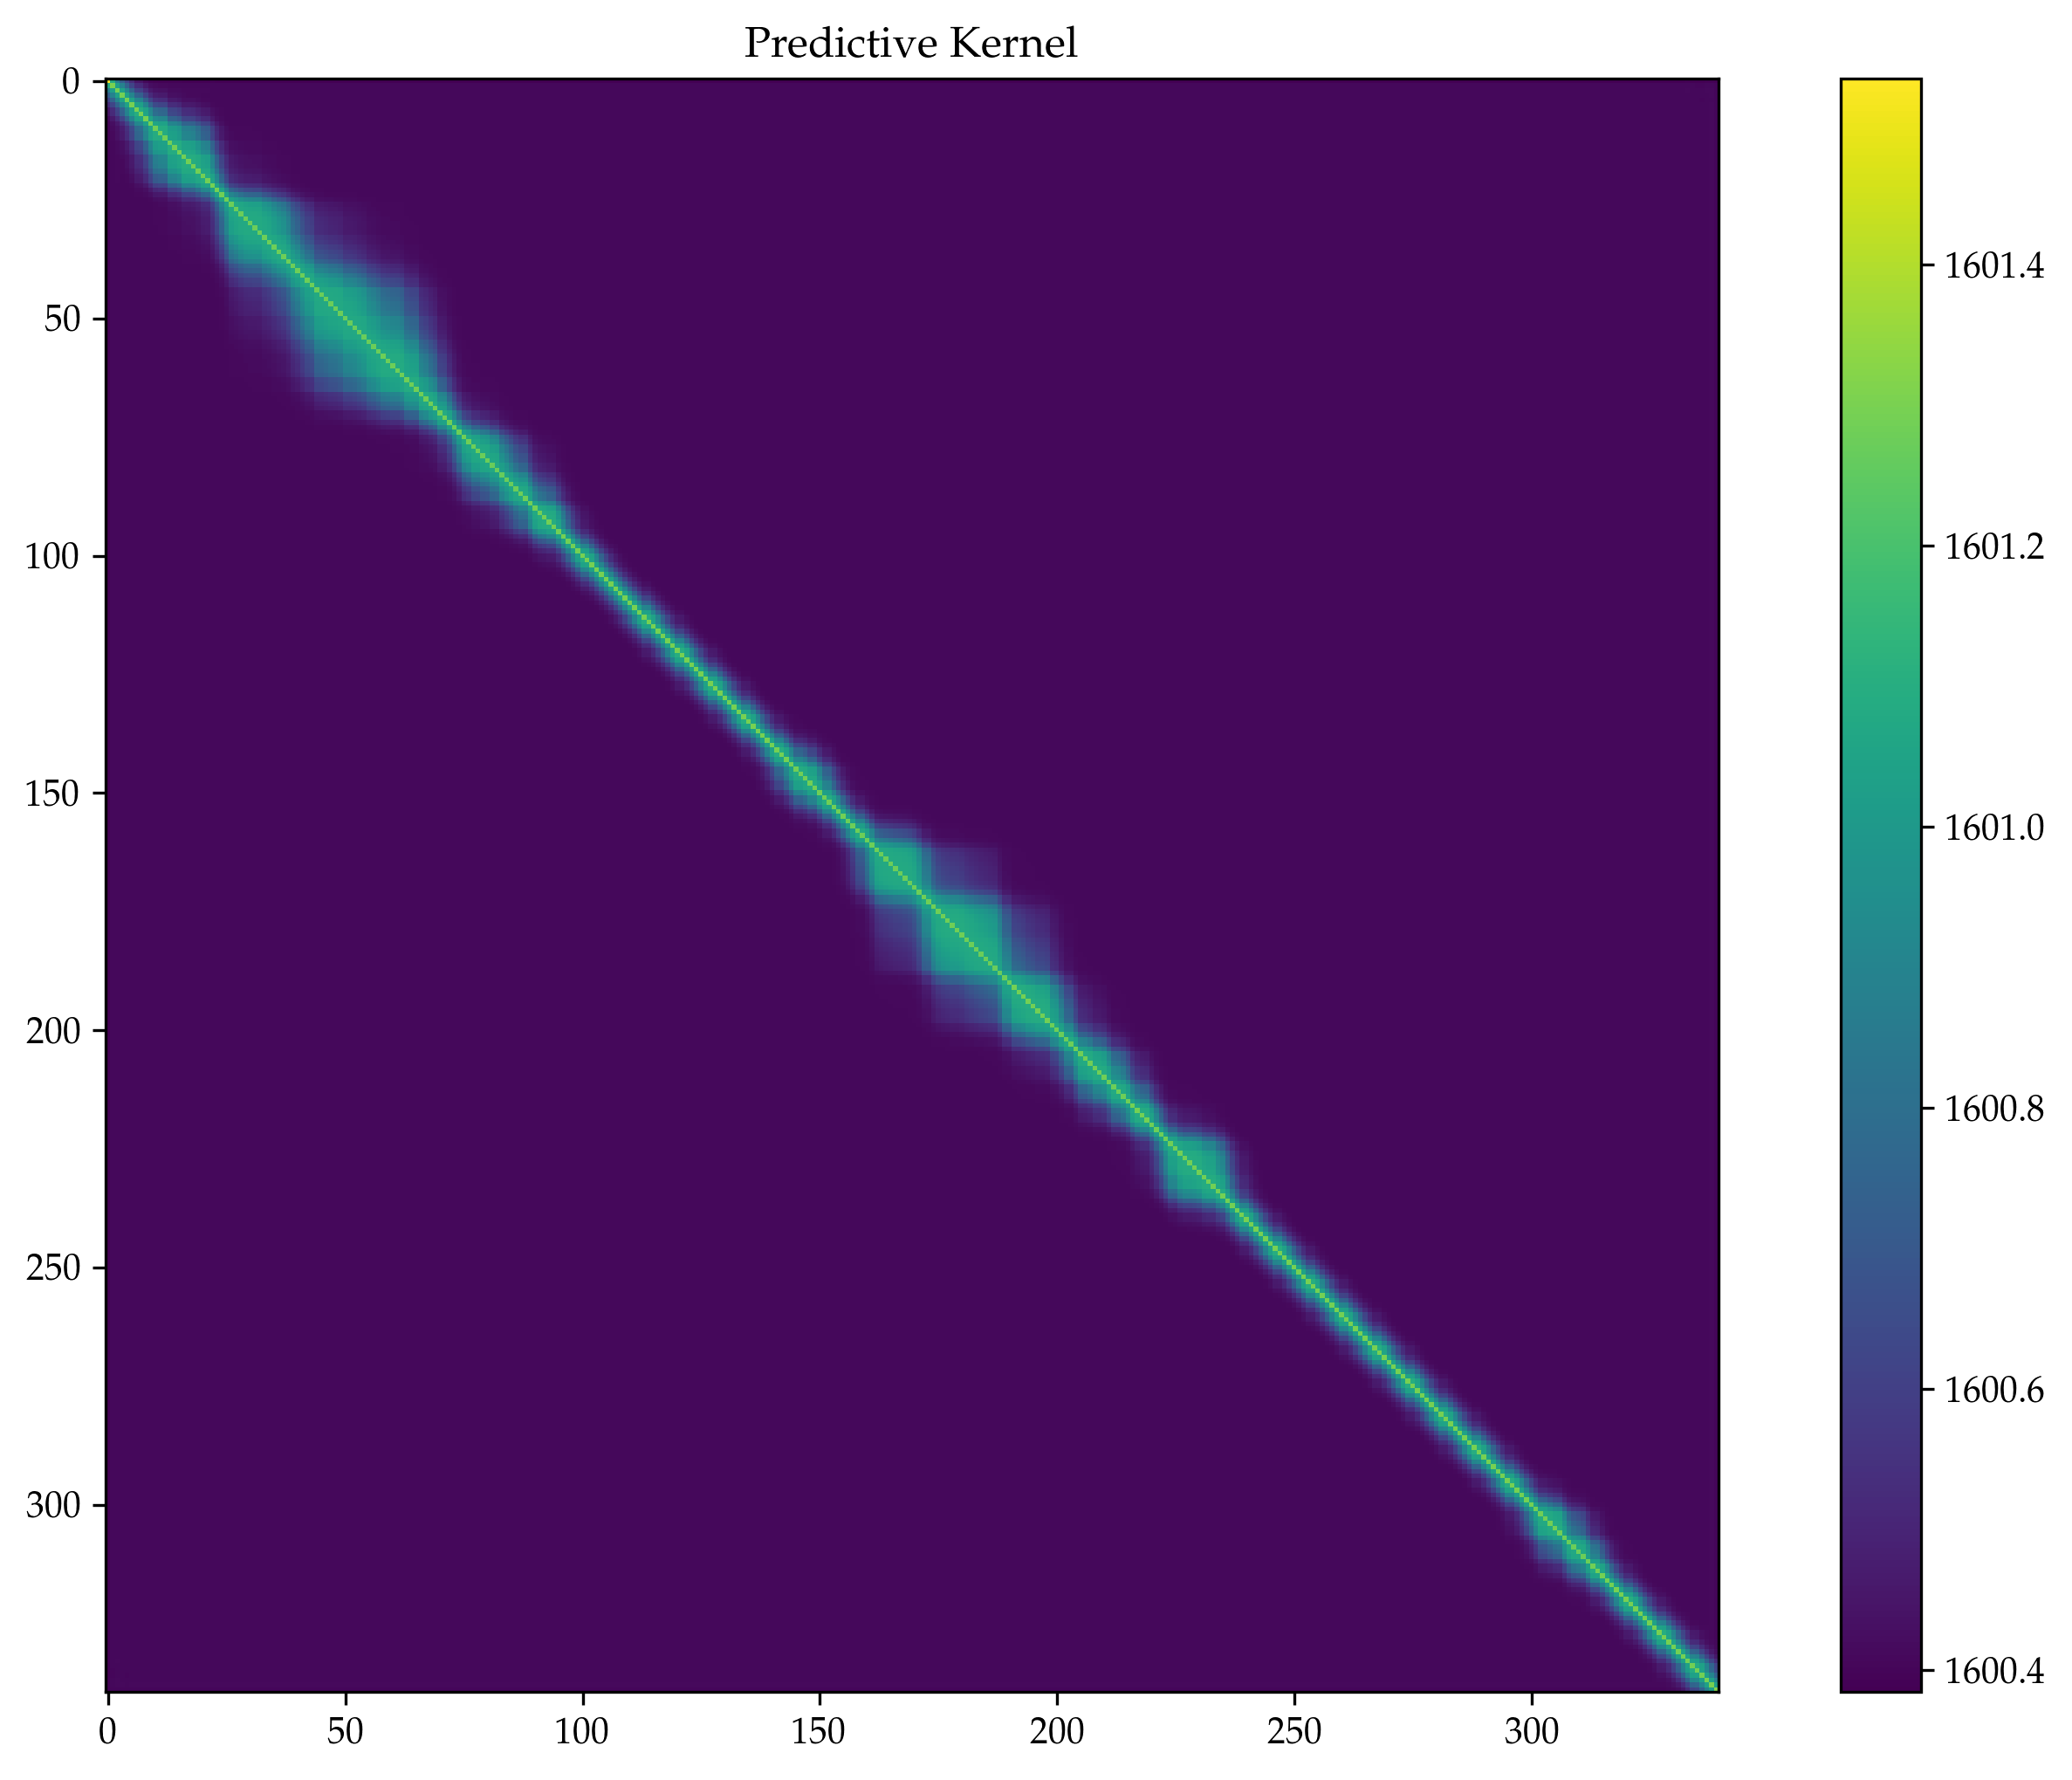

PyObject <matplotlib.colorbar.Colorbar object at 0x16bdd50a0>

In [12]:
begin
    plt.imshow(test_prediction[2])
    plt.title("Predictive Kernel")
    plt.colorbar()
end

## Predictive draws

Let's show some draws from the posterior fitted using the hourly data at nearby stations, but *not* the $T_n$ and $T_x$ records.

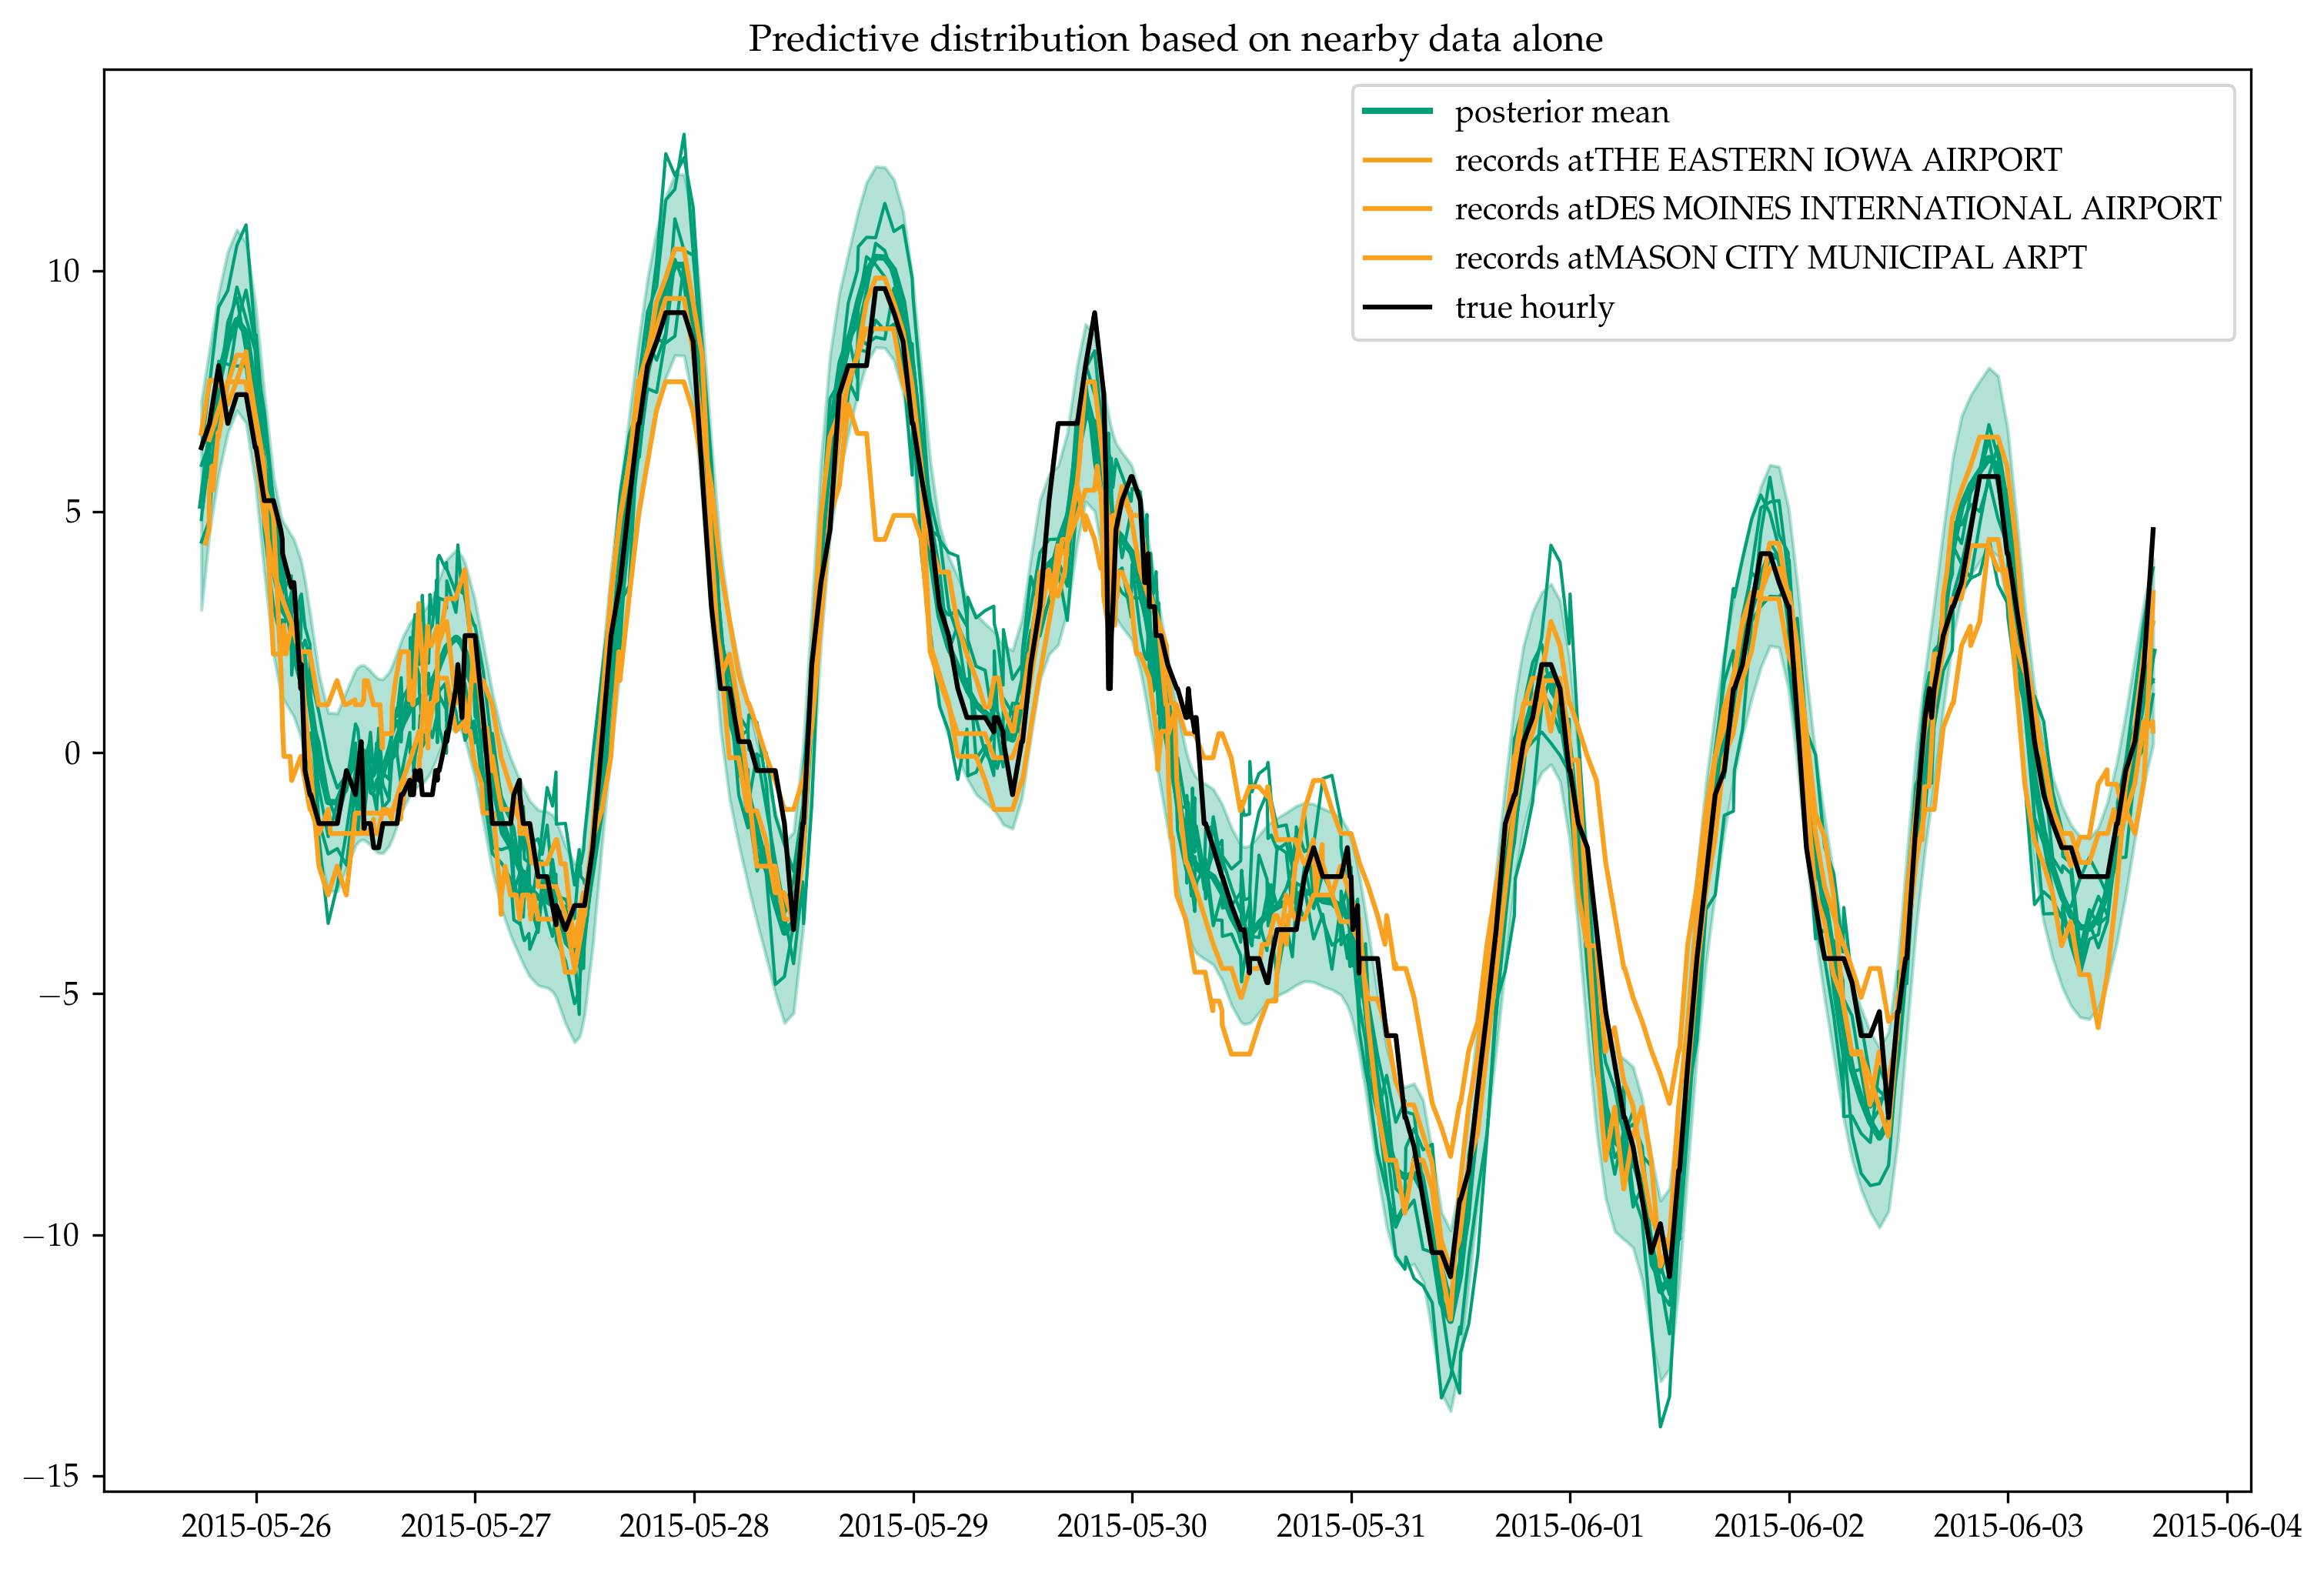

In [13]:
begin
    ts=test_subset.ts
    μ = test_prediction[1]
    Σ = test_prediction[2]
    nobsv = length(μ)
    
    centering = LinearAlgebra.I - ones(nobsv, nobsv) ./ nobsv
    Σ_centered = centering * Σ * centering
    distr = MultivariateNormal(μ, Σ)
    plt.plot(ts, μ, color="#009F77", linewidth=2, label="posterior mean")
    for _ in 1:5
        temp_sim = rand(distr)
        plt.plot(ts, temp_sim.-mean(temp_sim), color="#009F77", linewidth=1)
    end
    y_err = sqrt.(LinearAlgebra.diag(Σ_centered))
    plt.fill_between(ts, μ-2*y_err,μ+2*y_err, color="#009F77", alpha=0.3)
    for station in unique(train_subset.station)
        sdata = train_subset[train_subset.station.==station,:]
        ts=sdata.ts
        plt.plot(ts, sdata.temp.-mean(sdata.temp), color="#F8A21F", 
            label="records at"*iowa[:isdSubset][station,:NAME])
    end
    ts = test_subset.ts
    temp_true = test_subset.temp
    plt.plot(ts, temp_true.-mean(temp_true), 
        color="black", "-", label="true hourly")
    plt.legend(loc="best")
    plt.title("Predictive distribution based on nearby data alone")
end
;

It's interesting to note that the posterior mean is quite close to the truth, despite the very wide credible envelope. To me this suggests that the information available from nearby stations is underweighted. We should be making more confident predictions.

# Specifying STAN model

In [14]:
tmpdir=abspath("./stan_tmpdir")
imputation_model = TemperatureImputations.get_imputation_model(;pdir=tmpdir, seed=123)
;

## preparing Stan data

In [15]:
test_TxTn = DataFrames.combine(
    DataFrames.groupby(test_subset, :ts_day), 
    df -> (
        Tn=first(df.Tn), 
        Tx=first(df.Tx), 
        times_p_day=nrow(df),
    )
)

9×4 DataFrame
 Row │ ts_day      Tn       Tx       times_p_day 
     │ Date        Float64  Float64  Int64       
─────┼───────────────────────────────────────────
   1 │ 2015-05-26     15.6     25.6           46
   2 │ 2015-05-27     13.9     22.8           54
   3 │ 2015-05-28     13.9     26.7           27
   4 │ 2015-05-29     16.7     27.2           31
   5 │ 2015-05-30     12.8     26.7           59
   6 │ 2015-05-31      6.7     16.1           36
   7 │ 2015-06-01      6.7     19.4           28
   8 │ 2015-06-02     10.0     21.7           32
   9 │ 2015-06-03     15.0     23.9           27

In [16]:
imputation_data, ts_window = let
    μ = test_prediction[1]
    Σ = test_prediction[2]
    Σ_PD = PDMats.PDMat(Σ)
    nearby_pred = TemperatureImputations.NearbyPrediction(test_subset.ts, μ, Σ_PD)
    TnTx = test_TxTn
    date_start = test_subset.ts_day[1]
    hr_measure = iowa[:hr_measure]
    impute_window = Day(9)
    TemperatureImputations.prep_data(
            nearby_pred,
            TnTx,
            date_start,
            hr_measure,
            impute_window;
            ksmoothmax=50.0,
            epsilon=0.1)
end
;

# Running STAN

In [17]:
@time rc = StanSample.stan_sample(imputation_model, data=imputation_data, summary=true)
@assert success(rc)
(StanSample.read_samples(imputation_model; output_format=:mcmcchains)
    |> x -> StanSample.summarystats(x)
    |> display
)

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/imolk/Documents/Harvard/Natesh/TemperatureImputations/notebooks/stan_tmpdir/imputation.stan', line 60, column 8 to column 41)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/imolk/Documents/Harvard/Natesh/TemperatureImputations/notebooks/stan_tmpdir/imputation.stan', line 60, column 8 to column 41)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/imolk/Documents/Harvard/Natesh/TemperatureImputations/notebooks/stan_tmpdir/imputation.stan', line 60, column 8 to column 41)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/imolk/Documents/Harvard/Natesh/TemperatureImputations/notebooks/stan_tmpdir/imputation.stan', line 60, column 8 to column 41)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, th

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/imolk/Documents/Harvard/Natesh/TemperatureImputations/notebooks/stan_tmpdir/imputation.stan', line 60, column 8 to column 41)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite! (in '/Users/imolk/Documents/Harvard/Natesh/TemperatureImputations/notebooks/stan_tmpdir/imputation.stan', line 60, column 8 to column 41)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, th

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/imolk/Documents/Harvard/Natesh/TemperatureImputations/notebooks/stan_tmpdir/imputation.stan', line 60, column 8 to column 41)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in '/Users/imolk/Documents/Harvard/Natesh/TemperatureImputations/notebooks/stan_tmpdir/imputation.stan', line 60, column 8 to column 41)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then

377.843652 seconds

Summary Statistics
   parameters      mean       std   naive_se      mcse         ess      rhat 
       Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

   w_uncorr.1   -0.0166    0.0253     0.0004    0.0004   2979.5619    1.0004
   w_uncorr.2   -0.2287    0.9612     0.0152    0.0117   5340.3064    0.9997
   w_uncorr.3   -0.3564    0.9496     0.0150    0.0112   5540.6535    0.9999
   w_uncorr.4   -0.4529    0.8881     0.0140    0.0124   4800.1885    0.9991
   w_uncorr.5   -0.3750    0.8170     0.0129    0.0106   5799.0196    0.9996
   w_uncorr.6    0.0631    0.7979     0.0126    0.0115   5514.0571    1.0000
   w_uncorr.7    0.3618    0.9391     0.0148    0.0117   6012.1581    0.9993
   w_uncorr.8    0.2115    0.9486     0.0150    0.0118   8146.4704    0.9993
   w_uncorr.9    0.2665    0.9984     0.0158    0.0136   6367.0457    0.9996
  w_uncorr.10    0.2677    0.9926     0.0157    0.0122   6426.3528    0.9998
  w_uncorr.11    0.2272    0.9922     0.0157    0.0108

 (9.82 M allocations: 696.775 MiB, 0.05% gc time)


In [18]:
ENV["LINES"] = 1000
(StanSample.read_samples(imputation_model; output_format=:mcmcchains)
    |> x -> StanSample.summarystats(x)
    |> DataFrame
)

698×7 DataFrame
 Row │ parameters     mean          std        naive_se     mcse         ess   ⋯
     │ Symbol         Float64       Float64    Float64      Float64      Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ w_uncorr.1     -0.0166338    0.0252934  0.000399924  0.000440799   2979 ⋯
   2 │ w_uncorr.2     -0.228673     0.96123    0.0151984    0.0117365     5340
   3 │ w_uncorr.3     -0.35639      0.94959    0.0150143    0.0112314     5540
   4 │ w_uncorr.4     -0.452879     0.888061   0.0140415    0.0123701     4800
   5 │ w_uncorr.5     -0.374963     0.816996   0.0129178    0.0106015     5799 ⋯
   6 │ w_uncorr.6      0.0631187    0.797878   0.0126156    0.0115281     5514
   7 │ w_uncorr.7      0.361838     0.939089   0.0148483    0.0117398     6012
   8 │ w_uncorr.8      0.211508     0.948561   0.0149981    0.0118051     8146
   9 │ w_uncorr.9      0.266511     0.998441   0.0157867    0.0135807     6367 ⋯
  10 │ w_uncorr.10     0.267674     0.992592   0.0156943    0.0121987     6426
  11 │ w_uncorr.11     0.227155     0.992219   0.0156884    0.0108207     7535
  12 │ w_uncorr.12     0.155002     0.977588   0.015457     0.0103575     7479
  13 │ w_uncorr.13     0.103736     0.970476   0.0153446    0.00980438    9007 ⋯
  14 │ w_uncorr.14     0.15724      0.962987   0.0152262    0.0131591     7761
  15 │ w_uncorr.15     0.111012     0.999682   0.0158064    0.0113347     9145
  16 │ w_uncorr.16     0.074095     0.992583   0.0156941    0.0118442     7049
  17 │ w_uncorr.17     0.109531     0.973679   0.0153952    0.0126518     5625 ⋯
  18 │ w_uncorr.18     0.0793011    0.999433   0.0158024    0.00821732    7956
  19 │ w_uncorr.19     0.0348641    1.00347    0.0158663    0.0111852     8423
  20 │ w_uncorr.20     0.0451705    1.00398    0.0158743    0.010825      6330
  21 │ w_uncorr.21     0.0506081    0.987895   0.01562      0.0117798     7573 ⋯
  22 │ w_uncorr.22     0.0216787    0.971322   0.015358     0.013217      6152
  23 │ w_uncorr.23     0.0107121    0.986837   0.0156033    0.014027      6336
  24 │ w_uncorr.24     0.000105056  0.94721    0.0149767    0.0148775     4292
  25 │ w_uncorr.25     0.0587481    1.00289    0.0158571    0.0147602     4878 ⋯
  26 │ w_uncorr.26     0.142935     0.987819   0.0156188    0.0120241     5229
  27 │ w_uncorr.27     0.121762     0.992256   0.0156889    0.0159942     5785
  28 │ w_uncorr.28     0.0751702    0.997435   0.0157708    0.0146033     5607
  29 │ w_uncorr.29     0.0701012    1.03067    0.0162963    0.013501      6649 ⋯
  30 │ w_uncorr.30     0.0733057    1.00497    0.01589      0.0118867     6291
  31 │ w_uncorr.31     0.0393812    1.02705    0.0162391    0.0144065     7142
  32 │ w_uncorr.32     0.0326785    0.978975   0.015479     0.0121682     6732
  33 │ w_uncorr.33     0.0347606    1.01443    0.0160396    0.0103985     8615 ⋯
  34 │ w_uncorr.34     0.0331437    0.985788   0.0155867    0.0117569     6511
  35 │ w_uncorr.35     0.0498412    0.994471   0.015724     0.0128261     7194
  36 │ w_uncorr.36     0.0470633    0.987856   0.0156194    0.0142174     6003
  37 │ w_uncorr.37     0.0661023    1.04905    0.016587     0.0129227     7435 ⋯
  38 │ w_uncorr.38     0.084029     1.07336    0.0169714    0.0127486     8546
  39 │ w_uncorr.39     0.0707404    0.992503   0.0156929    0.0132049     5049
  40 │ w_uncorr.40     0.104599     1.03296    0.0163325    0.011452      6275
  41 │ w_uncorr.41     0.12966      1.01941    0.0161182    0.0124091     6559 ⋯
  42 │ w_uncorr.42     0.166091     1.02805    0.0162549    0.0119178     7335
  43 │ w_uncorr.43     0.139421     1.00676    0.0159183    0.00963636    8602
  44 │ w_uncorr.44     0.126216     0.990429   0.0156601    0.0129585     7642
  45 │ w_uncorr.45     0.17311      0.987105   0.0156075    0.0101391     8548 ⋯
  46 │ w_uncorr.46     0.100129     0.995438   0.0157393    0.0116565     8033
  47 │ w_uncorr.47     0.071602     1.01119    0.0159883    0.0109789     6729
  48

In [19]:
mcmc = StanSample.read_samples(imputation_model; output_format=:mcmcchains)
chains = mcmc.value
;

In [20]:
temp_impt_headers = [Symbol("temp_impt.$i") for i in 1:length(ts_window)]
temp_impute = chains[var=temp_impt_headers]
;

# Plotting

In [21]:
# stacked_impute=vcat((temp_impute[:,:,i] for i in 1:size(temp_impute,3))...)
# sorted_impute = sort(stacked_impute; dims=1);
# nsamples=size(sorted_impute,1)
# extract and 2.5th and 97.5th percentiles
# of the imputations
imputed_025 = [quantile(vec(chains[:,i,:]), 0.025) for i in temp_impt_headers]
imputed_975 = [quantile(vec(chains[:,i,:]), 0.975) for i in temp_impt_headers]
;

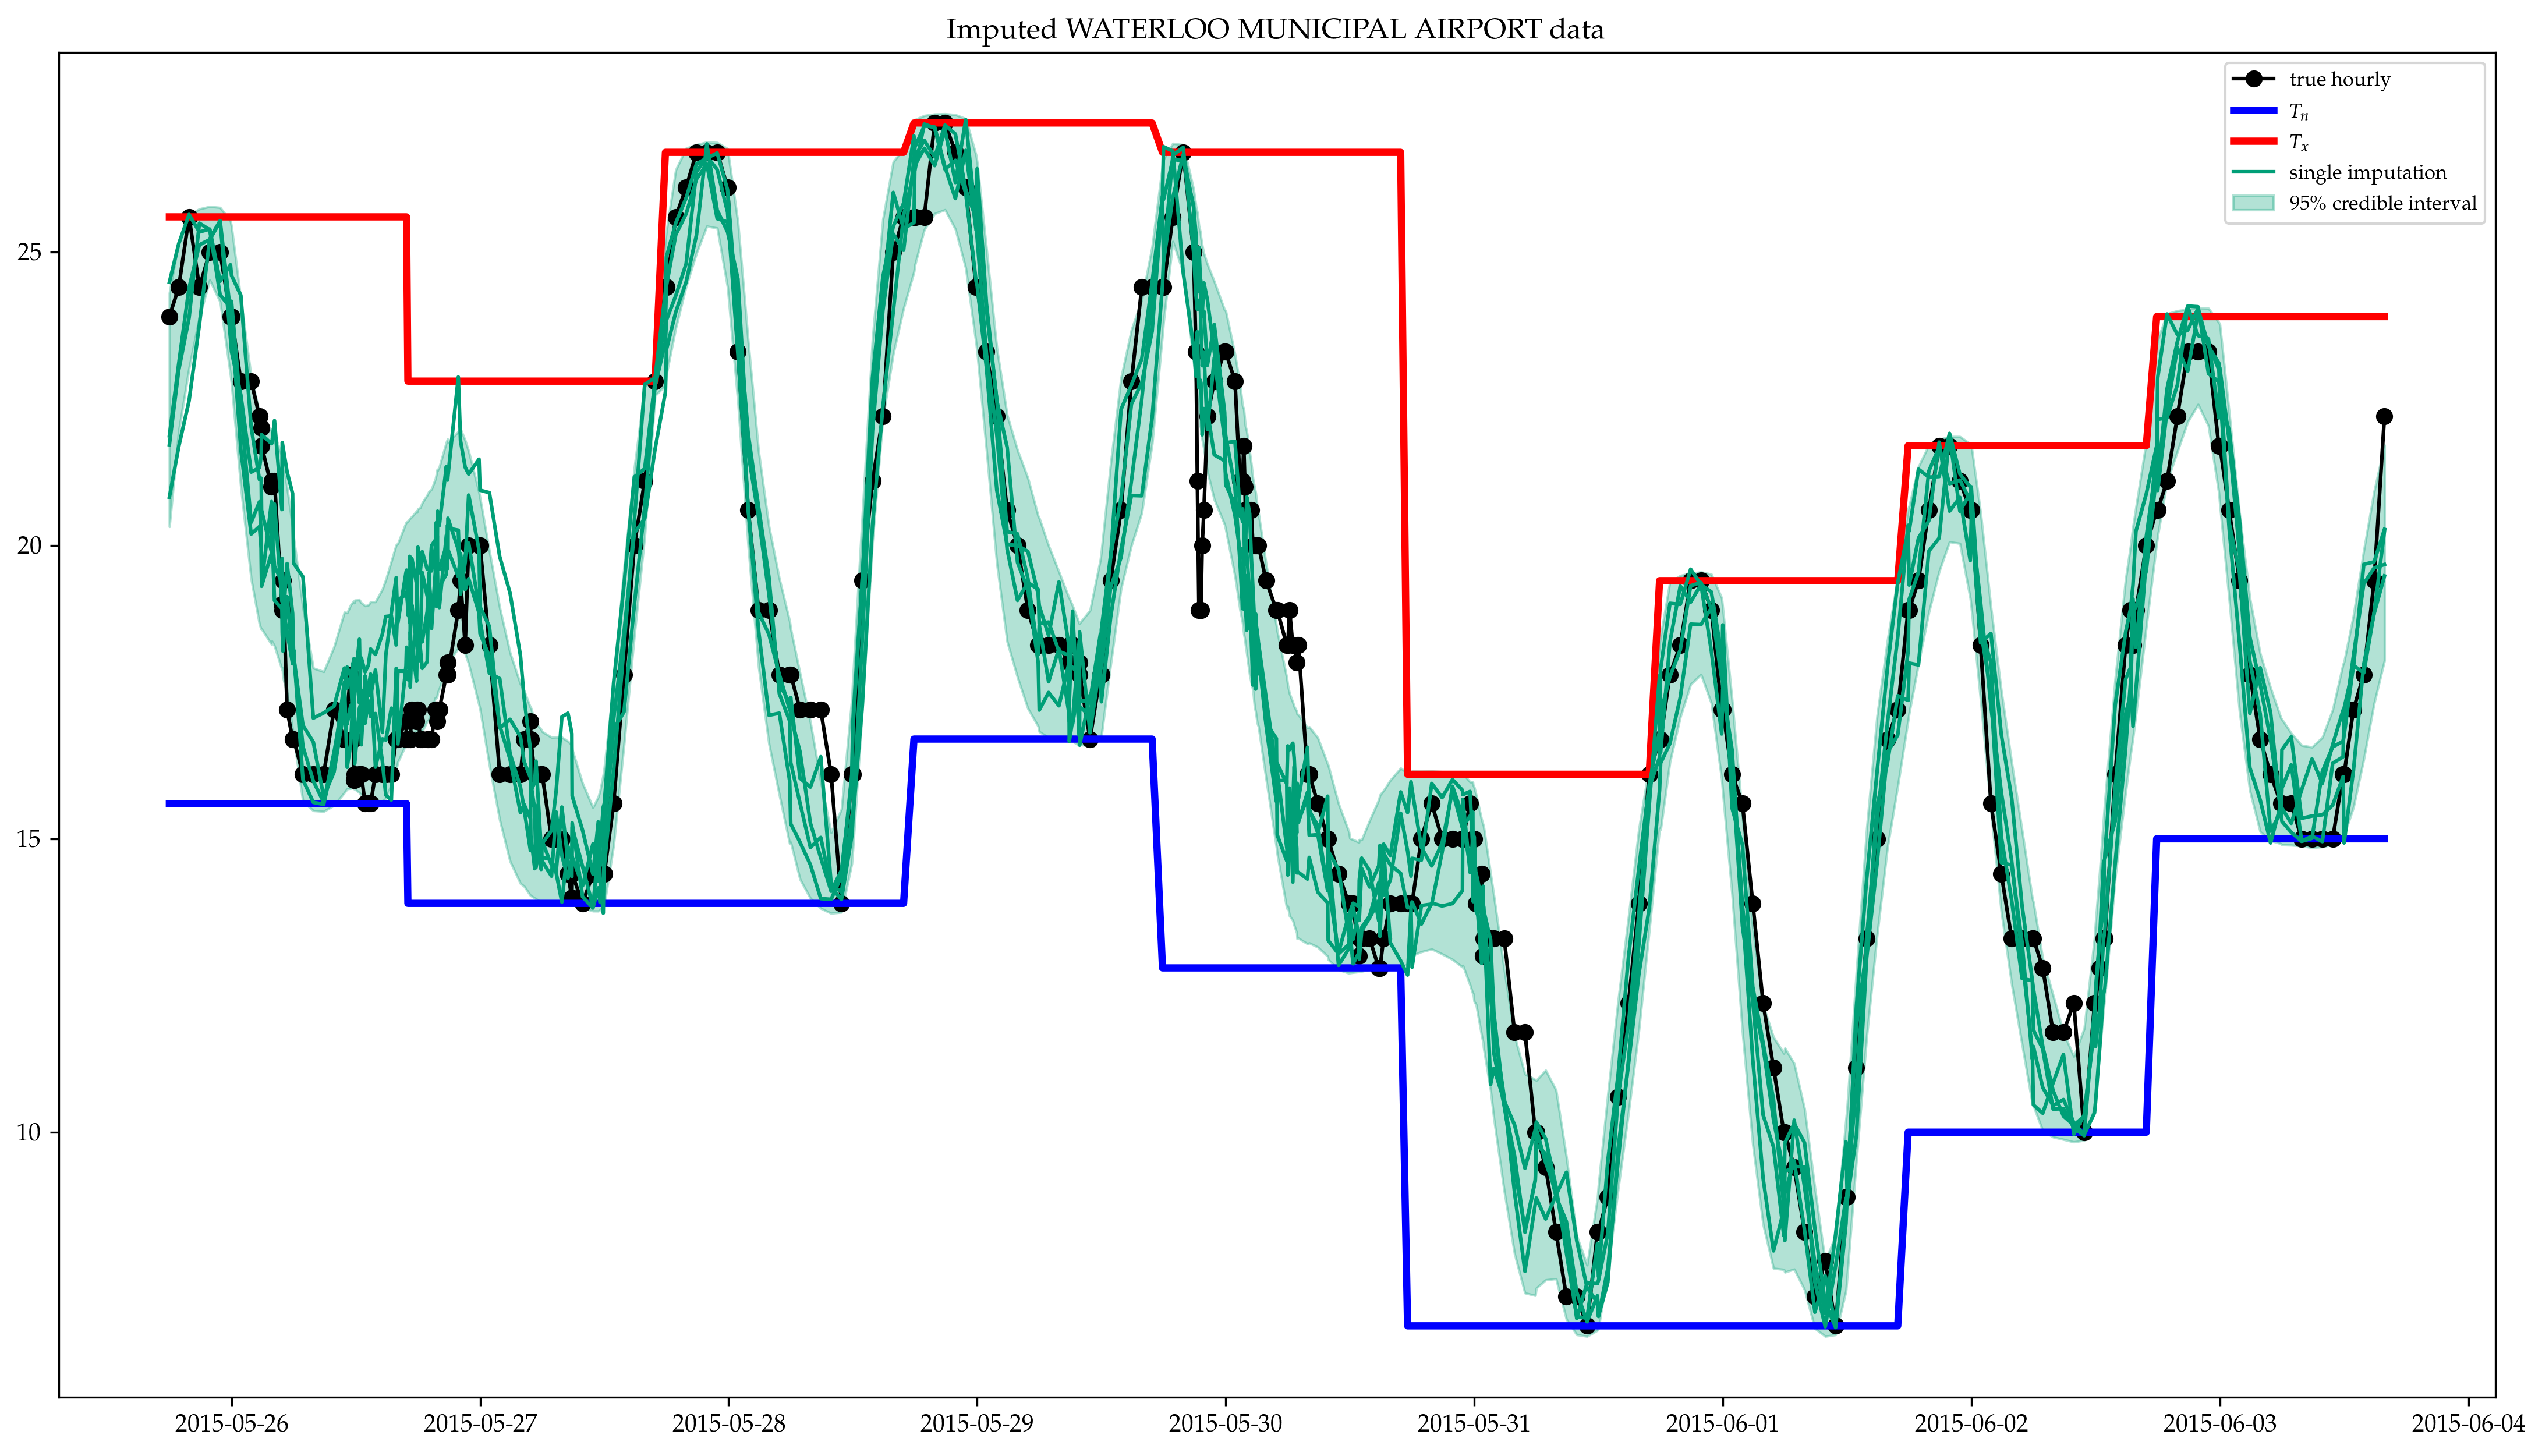

In [22]:
begin
    ts = test_subset.ts
    plt.plot(ts, test_subset.temp, 
        color="black", "o-", label="true hourly")
    plt.plot(ts, test_subset.Tn, 
        color="blue", linewidth=3, label=L"$T_n$")
    plt.plot(ts, test_subset.Tx, 
        color="red", linewidth=3, label=L"$T_x$")
    plt.fill_between(ts, imputed_025, imputed_975, 
        color="#009F77", alpha=0.3, label=L"$95 \% $ credible interval")
    plt.plot(ts, temp_impute[250,:,1],
        color="#009F77", label="single imputation")
    for i in 2:size(temp_impute,3)
        plt.plot(ts, temp_impute[250,:,i], color="#009F77")
    end
    plt.legend(loc="best", fontsize="small")
    plt.gcf().set_size_inches(18.0, 10.0)
    plt.title(@sprintf("Imputed %s data", iowa[:isdSubset][iowa[:itest],:NAME]))
end
;

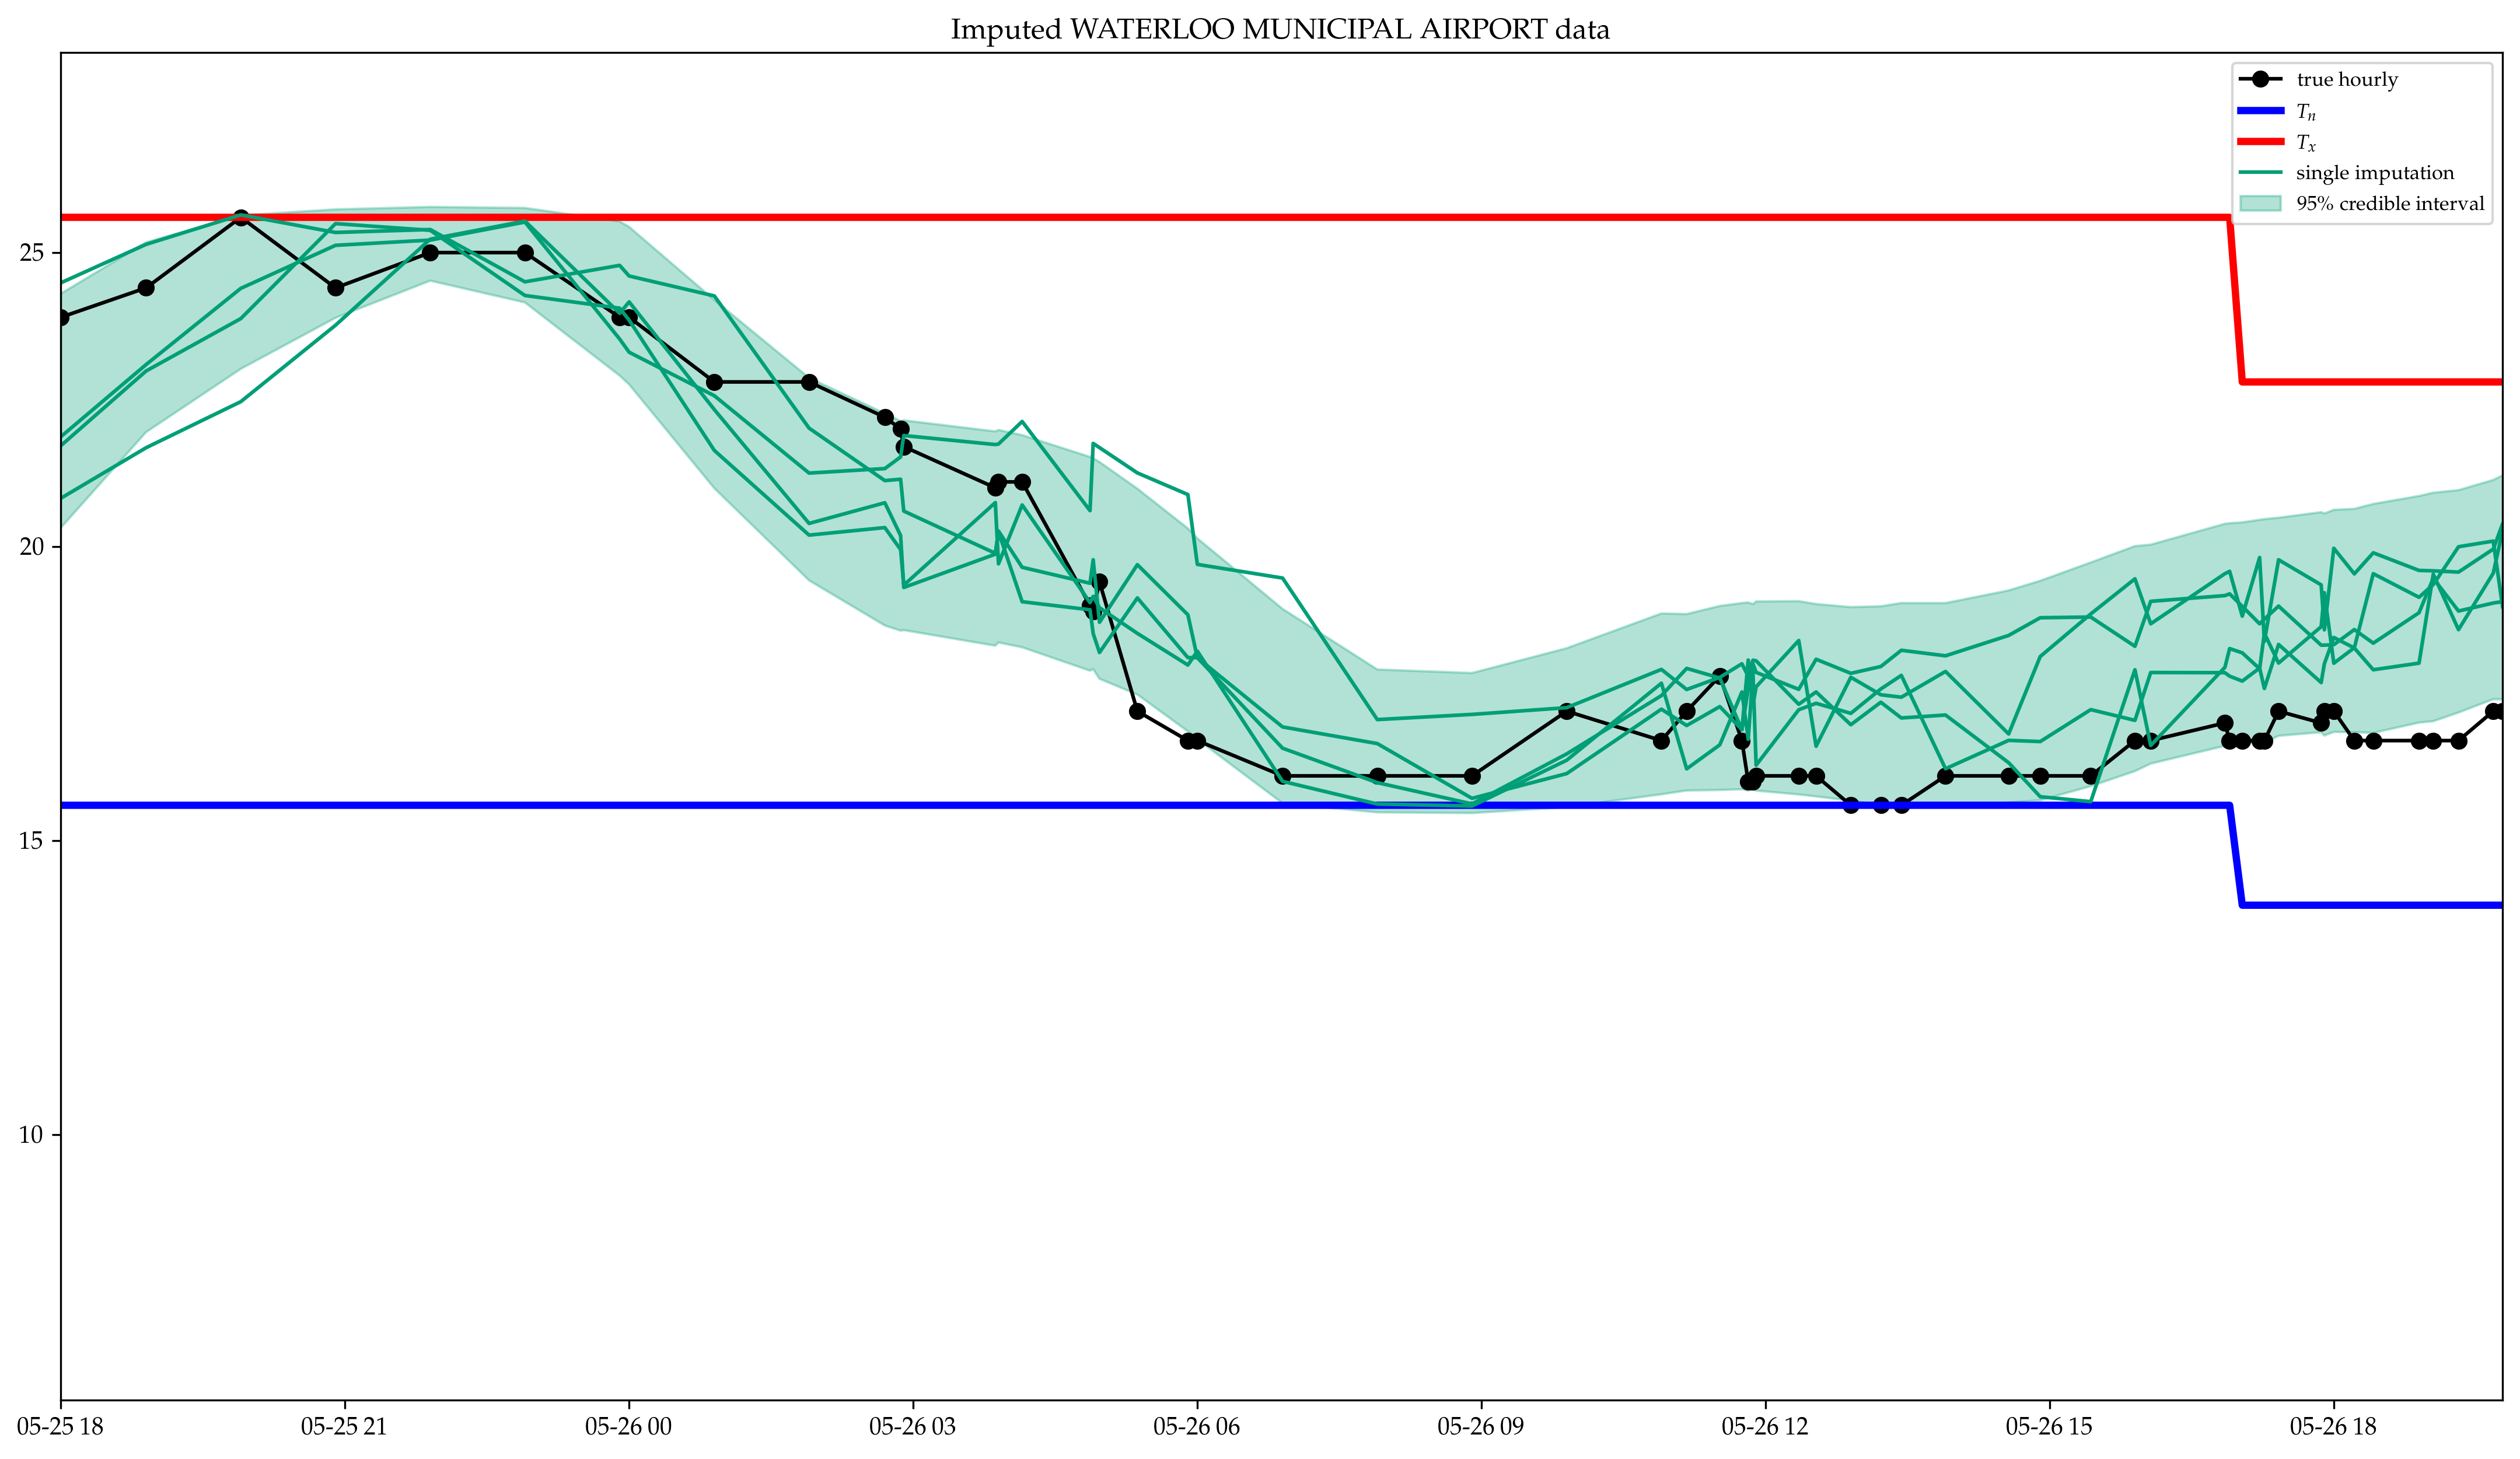

In [23]:
begin
    ts = test_subset.ts
    plt.plot(ts, test_subset.temp, 
        color="black", "o-", label="true hourly")
    plt.plot(ts, test_subset.Tn, 
        color="blue", linewidth=3, label=L"$T_n$")
    plt.plot(ts, test_subset.Tx, 
        color="red", linewidth=3, label=L"$T_x$")
    plt.fill_between(ts, imputed_025, imputed_975, 
        color="#009F77", alpha=0.3, label=L"$95 \% $ credible interval")
    plt.plot(ts, temp_impute[250,:,1],
        color="#009F77", label="single imputation")
    for i in 2:size(temp_impute,3)
        plt.plot(ts, temp_impute[250,:,i], color="#009F77")
    end
    plt.legend(loc="best", fontsize="small")
    plt.gcf()[:set_size_inches](18.0, 10.0)
    plt.title(@sprintf("Imputed %s data", iowa[:isdSubset][iowa[:itest],:NAME]))
    plt.xlim(ts[1], ts[60])
end
;

# Observations

Note that we've separated the imputation procedure into two separate steps, which use two separate sources of information about the temperatures:

1. the hourly temperatures at nearby stations
2. the $T_n$ and $T_x$ records at the test station

The advantage is that incorporating the nearby hourly temperatures can be done analytically once we specify a Gaussian Process model. So that step is computationally very quick. We then only use SmoothHMC in Stan to add the second source of information. 
The STAN model is therefore hugely simplified, and the fitting time is greatly reduced.

We're getting good convergence diagnostics from Stan, and the imputed temperatures:
1. stay within the constraints imposed by $T_n$ and $T_x$
2. are very close to the true temperatures at Waterloo Municipal Airport
3. on May 27th and 28th the model accurately finds that the high for both days is set in the same afternoon, and that the peak of the previous diurnal cycle does not get recorded

Sources of worry are:
* the true temperatures sometimes drift out of the 95% envelope, though not necessarily more often than they should.